In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from urllib.parse import urlencode
import scipy.stats as st
from tqdm.auto import tqdm
plt.style.use('ggplot')

# Проект: вариант 1
# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
# считаем исходные данные
df2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-markovicheva-26/shared/problem2.csv', sep=';')
df2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [3]:
df2.shape

(404770, 3)

In [4]:
df2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
df2.user_id.nunique()

404770

In [6]:
# проверка на отсутствие значений
df2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [7]:
# проверка на отсутствие дубликатов
df2.duplicated().sum()

0

In [8]:
# контрольная группа
control = df2[df2.testgroup == 'a']
control.reset_index(drop=True, inplace=True)
control.head()

,user_id,revenue,testgroup
0,2,0,a
1,3,0,a
2,10,0,a
3,11,0,a
4,12,0,a


In [9]:
# число всех пользователей контрольной группы совпадает с условием
control.shape

(202103, 3)

In [10]:
# число платящих игроков контрольной группы совпадает с условием
control[control.revenue != 0].revenue.count()

1928

In [11]:
# посчитаем ARPU для контрольной группы
control_ARPU = control.revenue.sum() / control.shape[0]
control_ARPU

25.413719736965806

In [12]:
# тестовая группа
test = df2[df2.testgroup == 'b']
test.reset_index(drop=True, inplace=True)
test.head()

,user_id,revenue,testgroup
0,1,0,b
1,4,0,b
2,5,0,b
3,6,0,b
4,7,0,b


In [13]:
# число всех пользователей тестовой группы совпадает с условием
test.shape

(202667, 3)

In [14]:
# число платящих игроков тестовой группы совпадает с условием
test[test.revenue != 0].revenue.count()

1805

In [15]:
# посчитаем ARPU для тестовой группы
test_ARPU = test.revenue.sum() / test.shape[0]
test_ARPU

26.75128659327863

In [16]:
# отличие в 5% - совпадает с условием
100 * test_ARPU / control_ARPU

105.2631683600699

Прежде всего, представляется, что лучше начать с рассмотрения дохода в контрольной и тестовой группах. Стоит проверить, если ли стат. значимые различия между двумя группами.

In [17]:
# отберем только платящих пользователей из двух групп
control_paying = control[control.revenue > 0]
test_paying = test[test.revenue > 0]

In [18]:
# посмотрим подробнее
control_paying.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [19]:
test_paying.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Видно, что между платящими игроками контрольной группы и тестовой есть ряд различий.

Во-первых, шире размах значений в контрольной группе - от 200 до 37433 у.е., тогда так в тестовой от 2000 у.е. до 4000 у.е.

Во-вторых, на первый взгляд, в контрольной группе больше таких пользователей, которые платили меньше (медиана = 311, тогда как в тестовой она = 3022).

В-третьих, опять же на первый взгляд, значения в контрольной группе кажутся распределенными более неравномерно, чем в тестовой (см. процентили) при более-менее одинаковом количестве пользователей.

Посмотрим на распределение на графиках.

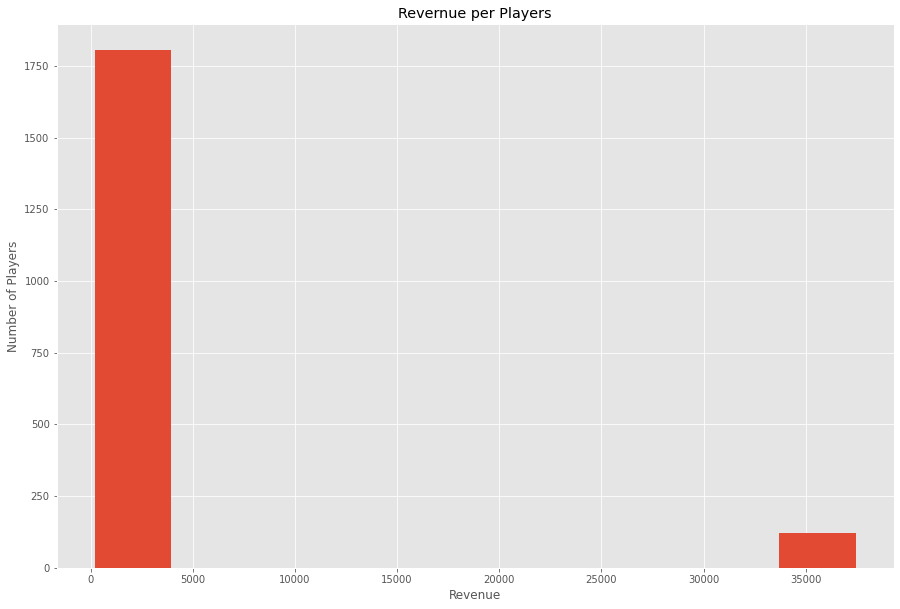

In [20]:
# контрольная группа
plt.figure(figsize=(15, 10))
plt.title('Revernue per Players')
plt.xlabel('Revenue')
plt.ylabel('Number of Players')
control_paying.revenue.hist()

<Figure size 1080x720 with 0 Axes>

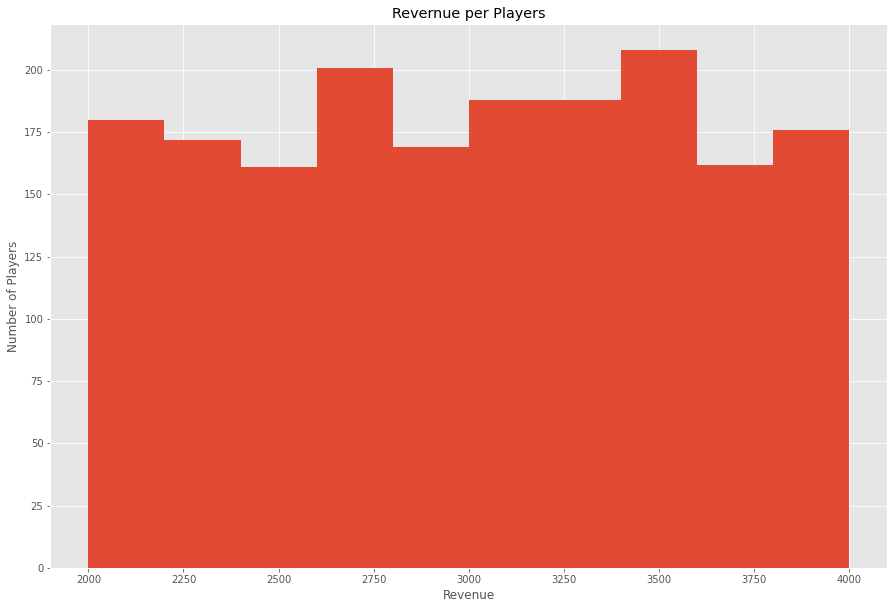

In [21]:
# тестовая группа
plt.figure(figsize=(15, 10))
plt.figure(figsize=(15, 10))
plt.title('Revernue per Players')
plt.xlabel('Revenue')
plt.ylabel('Number of Players')
test_paying.revenue.hist()

Наблюдаем, что, действительно, в тестовой группе наблюдаеся, скорее, один кластер платящих пользователей, в то время как в контрольной визуально присутствует чёткое деление на два кластера: доход до 5000 у.е. (абсолютное большинство игроков) и доход приблизительно от 34000 с пользователя (100+ человек из 1928).

Судя по графикам, распределения будут отличаться от нормальных (особенно если включить неплатящих игроков), но проверим дополнительно на двух тестах - Шапиро-Уилка и scipy.stats.normaltest().

In [22]:
# распределение групп на нормальность: тест Шапиро-Уилка (но на больших выборках может сработать некорректно)
st.shapiro(control_paying.revenue)
# p значительно меньше 0.05 - есть основания утверждать, что данные распределены ненормально в контрольной группе
# платящих пользователей

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [23]:
# распределение групп на нормальность: scipy.stats.normaltest()
st.normaltest(control_paying.revenue)
# p значительно меньше 0.05 - есть основания утверждать, что данные распределены ненормально в контрольной группе
# платящих пользователей

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [24]:
# распределение групп на нормальность: тест Шапиро-Уилка (но на больших выборках может сработать некорректно)
st.shapiro(test_paying.revenue)
# p значительно меньше 0.05 - есть основания утверждать, что данные распределены ненормально в тестовой группе
# платящих пользователей

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

In [25]:
# распределение групп на нормальность: scipy.stats.normaltest()
st.normaltest(test_paying.revenue)
# p значительно меньше 0.05 - есть основания утверждать, что данные распределены ненормально в тестовой группе
# платящих пользователей

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

In [26]:
# требование гомогенности дисперсий: тест Левена
st.levene(control_paying.revenue, test_paying.revenue)
# p значительно меньше 0.05 - есть основания подозревать негомогенность дисперсии
# среди платящих пользователей

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Дополнительно посмотрим на соблюдение требований к нормальности распределения и гомогенности дисперсий в контрольной и тестовых группах включая неплатящих пользователей.

In [27]:
st.normaltest(control.revenue)
# p значительно меньше 0.05

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [28]:
st.normaltest(test.revenue)
# p значительно меньше 0.05

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

In [29]:
st.levene(control.revenue, test.revenue)
# p значительно больше 0.05

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Таким образом, критерии для проведения t-теста не соблюдены. Не имеет смысла проводить его на обеих вариациях (с включением неплатящих пользователей и без них) контрольной и тестовой групп.

Проведём в таком случае U-тест, который менее чувствителен к экстремальным отклонениям от нормальности.

In [30]:
# включаем неплатящих пользователей
st.mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Нельзя уверенно утверждать, что между группами существует стат. значимые отличия (p > 0.05), однако весьма вероятно, что данный результат вызван включением неплатящих пользователей (доля которых составляет ~ 99% в контрольной группе и ~ 99.1% в тестовой группе).


Посмотрим, что будет, если убрать неплатящих игроков.

In [31]:
# исключаем неплатящих пользователей
st.mannwhitneyu(control_paying.revenue, test_paying.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Есть основания утверждать, что есть стат. значимые различия. Однако (sic!) нельзя понять, какой набор предложений лучше =(

Проведем бутстрап для средних (только платящие пользователи) с помощью функции из модуля по статистике, урок 9.

In [32]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
            
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

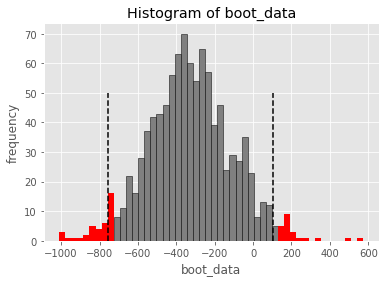

In [33]:
booted_data_paying = get_bootstrap(control_paying.revenue, test_paying.revenue)

In [34]:
# p > 0.05
booted_data_paying["p_value"]

0.132496695711163

In [35]:
# 0 попал в дов интервал - нет оснований отвергать нулевую гипотезу
booted_data_paying["quants"]

,0
0.025,-753.450298
0.975,103.469100


Бутстрап-анализ показывает, что нет оснований считать, что между двумя группами платящих пользователей есть стат. значимые различия (в отличие от U-теста).
Посмотрим на группу в общем.

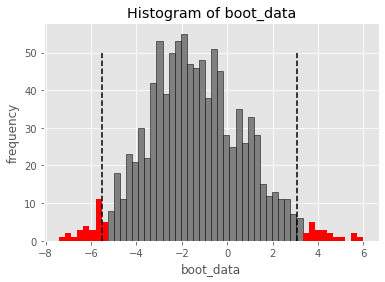

In [36]:
booted_data_paying_all = get_bootstrap(control.revenue, test.revenue)

In [37]:
# p > 0.05
booted_data_paying_all["p_value"]

0.5246598111822188

In [38]:
# 0 попал в дов интервал - нет оснований отвергать нулевую гипотезу
booted_data_paying_all["quants"]

,0
0.025,-5.519805
0.975,3.057744


Для полного состава групп также нет оснований утверждать, что существуют стат. значимые различия.

Снова взглянем на состав групп.

Выше отмечалось, что тестовая группа платящих игроков представляется более "монолитной" (пользователи внесли от 2000 до 4000 у.е., при этом количество дохода от пользователей распределено более-менее равномерно (25 процентиль - 2513 у.е., 50 процентиль - 3022 у.е., 75 процентиль - 3478 у.е. соответственно, при размахе от 2К до 4К).

В то же время контрольная группа платящих игроков явно разбивается на два кластера: до 5000 у.е. (абсолютное большинство пользователей) и доход приблизительно от 34000 с игрока (100+ человек из 1928). Посмотрим на эти два кластера подробнее.

In [39]:
# разобьём контрольную группу платящих на два кластера: кто платит меньше и кто платит больше
control_paying_less = control_paying[control_paying.revenue <= 5000]
control_paying_more = control_paying[control_paying.revenue > 5000]

In [40]:
# посмотрим данные подробнее
control_paying_less.revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [41]:
control_paying_more.revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

Заметно, что основная масса платящих пользователей контрольной группы внесли от 200 до 400 у.е., тогда как всего 123 человека (меньше одного процента платящих игроков!) делают "основную кассу" игре, внеся колоссальные суммы в ~37К каждый.

Прежде чем перейти к выводам по заданию, посмотрим на другие метрики: сумма дохода, средний и медианный доход среди платящих, ARPU, ARPPU, конверсия - по тестовой группе, контрольной группе, включающей в себя 123 самых "доходных" пользователей, и контрольной группе, не включающей в себя 123 самых "доходных" пользователей. 

In [42]:
# создадим контрольную группу, не включающую в себя 123 самых "доходных" пользователей
control_group_without_123_payers = control[control.revenue < 5000]
control_group_without_123_payers.revenue.describe()

count    201980.000000
mean          2.702926
std          28.985815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         400.000000
Name: revenue, dtype: float64

In [43]:
summary_df = pd.DataFrame(index=['total_number',
                                 'number_paid',
                                 'conversion_rate',
                                 'revenue_sum',
                                 'revenue_mean',
                                 'revenue_median',
                                 'ARPU',
                                 'ARPPU'])

# данные по тестовой группе
summary_df['test_group'] = [test.user_id.count(),
                            test_paying.user_id.count(),
                            test_paying.user_id.count() / test.user_id.count(),
                            test_paying.revenue.sum(),
                            test_paying.revenue.mean(),
                            test_paying.revenue.median(),
                            test.revenue.sum() / test.shape[0],
                            test.revenue.sum() / test_paying.shape[0]]


# данные по контрольной группе
summary_df['control_group'] = [control.user_id.count(),
                            control_paying.user_id.count(),
                            control_paying.user_id.count() / control.user_id.count(),
                            control_paying.revenue.sum(),
                            control_paying.revenue.mean(),
                            control_paying.revenue.median(),
                            control.revenue.sum() / control.shape[0],
                            control.revenue.sum() / control_paying.shape[0]]

# данные по контрольной группе с исключением наиболее прибыльных (менее одного процента от платящих) пользователей
# не рассчитываем часть метрик, так как они не покажут необходимое контрастное сравнение,
# кроме того факта, что метрика просто уменьшится (стоит "irrelevant")

summary_df['control_group_without_123_payers'] = ['irrelevant',
                            'irrelevant',
                            'irrelevant',
                            control_paying_less.revenue.sum(),
                            control_paying_less.revenue.mean(),
                            control_paying_less.revenue.median(),
                            control_group_without_123_payers.revenue.sum() / control_group_without_123_payers.shape[0],
                            control_group_without_123_payers.revenue.sum() / control_paying_less.shape[0]]



pd.options.display.float_format ='{:,.3f}'.format
summary_df

,test_group,control_group,control_group_without_123_payers
total_number,"202,667.000","202,103.000",irrelevant
number_paid,"1,805.000","1,928.000",irrelevant
conversion_rate,0.009,0.010,irrelevant
revenue_sum,"5,421,603.000","5,136,189.000",545937
revenue_mean,"3,003.658","2,663.998",302.458
revenue_median,"3,022.000",311.000,305.000
ARPU,26.751,25.414,2.703
ARPPU,"3,003.658","2,663.998",302.458


## Выводы

Тестовая и контрольная группы друг от друга отличаются.

Среди платящих пользователей тестовой группы не наблюдается ярко выраженное деление на кластеры: все они принесли доход от 2000 до 4000 у.е. каждый, при этом количество приносимого дохода на пользователя распределено относительно равномерно.

Среди платящих пользователей контрольной группы наблюдается чёткое деление: здесь 99% игроков приносят прибыль от 200 до 400 у.е. (на порядок меньше, чем в тестовой группе), тогда как в ней же существуют 123 игрока (менее 1% платящих), внесших ~37 тыс. у.е. каждый, сформировав превалирующую часть общего дохода группы.

Единственное совпадение у двух групп - в том, что менее 1% всех игроков приносят доход.

Стат. тесты показали следующее:
- бутстрап на всех пользователях и на платящих игроках, U-тест на всех пользователях: вероятность стат. значимых различий мала;
- U-тест на платящих пользователях - есть вероятность стат. значимых разлчиий между группами.

Если взглянуть на другие метрики (сумма дохода, средний и медианный доход среди платящих игроков, ARPU, ARPPU, конверсия), то тестовая группа обладает сравнительно более высокими показателями, за исключением конверсии.

Таким образом, главным преимуществом контрольной группы стало то, что ее предложения привлекли пусть небольшое количество, но игроков, готовых вкладывать по 37000 у.е. В то же время, набор предложений тестовой группы обеспечил более стабильный и сравнительно высокий доход среди платящих пользователей (если сопоставить с 99% платников контрольной группы).

У каждого подхода свои плюсы, но я бы выбрала набор предложений тестовой группы, пусть даже с риском потерять "почётных доноров". В ином случае выходит, что всего 1% платников контрольной группы делали доход, тогда как в тестовой все вкладывались равномерно, обеспечивая стабильный приток денег, к тому же, на порядок больше, чем 99% платящих контрольной группы. Вдобавок, в тестовой группе был заметен рост метрик ARPU и ARPPU.